### HEC Data Challenge 2023:
#### Case 1, Équipe 7
##### Alloprof

In [140]:
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
import scipy as sc
from scipy import stats
import copy
from collections import defaultdict, OrderedDict
from heapq import *
import copy
from scipy import linalg
from mpl_toolkits.mplot3d import Axes3D
# from prophet import Prophet
from datetime import datetime


In [224]:
com=pd.read_csv('details_communications-20230301.csv', delimiter=',')
# alltype=([('f0','str'),('f1','date'),('f2','str'),('f3','str'),('f4','str'), ('f5', ''), ('f6', 'f8'),('f7','f8'),('f8','f8'),('f9','i8'),('f10','i8')])
# com=np.genfromtxt(completename,delimiter=",",dtype=alltype,usecols=[0,1,2,3,4,5,6,7,8,9,10], names=True)
# com=np.array(times, dtype=object)
# com.head()
com = com.query("Date >= '2021-08-1'")
com['Date'] = pd.to_datetime(com['Date'])
com['hour'] = com['Date'].dt.hour
com['day_of_week'] = com['Date'].dt.dayofweek
com['Week_Number'] = com['Date'].dt.isocalendar().week
com["month"] = com["Date"].dt.month
com["Year"] = com["Date"].dt.year
com["MY"]= com['Date'].dt.strftime('%Y-%m')
# com['heure'] = com.Time.str[0:2]
com.head()

,Conversation_ID,Date,Time,Agent,Service,Direction,Langue,Niveau,Matiere,temps_comm,temps_attente,hour,day_of_week,Week_Number,month,Year,MY
6402,85395466-e939-5f6f-a135-0eac412ca01f,2021-08-12,08:56,VvFRUkuGXkm7BFLOe+/Fkirw5D8=,Call,direct,fr,NaN,NaN,5,NaN,0,3,32,8,2021,2021-08
6403,904ef45f-45b9-5471-9966-1a856689bbc6,2021-08-12,20:00,VvFRUkuGXkm7BFLOe+/Fkirw5D8=,SMS,rappel,fr,NaN,NaN,14,3.0,0,3,32,8,2021,2021-08
6404,2dd090fd-e56e-523f-bf8f-ad1b57b9ad2a,2021-08-12,08:52,VvFRUkuGXkm7BFLOe+/Fkirw5D8=,Call,rappel,fr,NaN,NaN,6,3.0,0,3,32,8,2021,2021-08
6405,e8d8ceca-f865-5701-ac7a-ff7a9a531d2e,2021-08-24,16:40,VvFRUkuGXkm7BFLOe+/Fkirw5D8=,Chat,direct,fr,NaN,NaN,3,6.0,0,1,34,8,2021,2021-08
6406,cc52e125-c19e-56f6-9737-932e19b19161,2021-08-25,07:36,Px+R4MtCavrfnecAZkTmz8y5OPU=,Chat,direct,fr,NaN,NaN,1,59.0,0,2,34,8,2021,2021-08


In [215]:
agents_df=pd.read_csv('agents-20230301.csv', delimiter=',')
agents_df.head()

,Agent,Skills,Langue
0,QwX/U1D2E197WXPFWQA1sZTZvFU=,math,en
1,OVF4/s8GtVh2sYbpSNflH5Sg8Yg=,math,en
2,QCuwKXEype1aPX+1ubv3ops0fKQ=,math,en
3,SeDGBN1XUIGQlUt5Xktgepe2ghM=,math,en
4,BcbMaUTYagkAETzwJmM57Hw+Yao=,math,en


In [220]:
len(agents_df.Skills.value_counts())

42

In [236]:
list_matiere_unique = com[~com.Matiere.isna()].Matiere.unique()[:-1]
print(list_matiere_unique)
list_matiere_unique.shape

['education_financiere' 'math' 'monde_contemporain' '_' 'sciences'
 'geographie' 'physique' 'chimie' 'francais' 'histoire' 'anglais' 'autre'
 'math_3_5' 'math_1_2' 'geo_histoire']


(15,)

In [242]:
def ReplaceSkill(x, skill_list):
    for skill in skill_list:
        if(str(skill) in x):
            return skill
        

agents_df.Skills = agents_df.Skills.map(lambda x: ReplaceSkill(x, skill_list=com[~com.Matiere.isna()].Matiere.unique()))

In [243]:
agents_gb_df = agents_df.groupby(['Agent']).agg(lambda x: ','.join(x))
agents_gb_df['Skills'] = agents_gb_df['Skills'].map(lambda x: x.split(','))
agents_gb_df.head()

,Skills,Langue
Agent,,
+FTsDHZEVij6S/YlUmkBAjxYX40=,"[autre, math, math, sciences, math, autre, fra...","en,en,en,en,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,f..."
+kA//C9qAVGLtQascCuOayH13S0=,"[math, sciences, math, math, autre, francais, ...","en,en,en,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr"
/Cdv04f54regdIJ4D/THAvWXnUA=,"[math, math, math, sciences, _, math, math]","fr,fr,fr,fr,fr,fr,fr"
0DuJNnNoWxANjD3LRqPfqjjCRTc=,"[math, autre, francais, _, math, _, _, _, _, _...","fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr"
0FJLzharSFPd1pmNf/Dt25iXkVc=,"[math, math, autre, math, math, sciences, math...","en,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr,fr"


In [244]:
len(agents_gb_df.Skills.value_counts())

130

In [245]:
agents_gb_df['Skills'].map(len).describe()

count    140.000000
mean      11.871429
std        6.729985
min        1.000000
25%        7.000000
50%       10.000000
75%       16.000000
max       29.000000
Name: Skills, dtype: float64

In [246]:
count = 0
for index, col in agents_gb_df.iterrows():
    count += com[com.Agent == index].Matiere.isin(col.Skills).sum()
count/com.shape[0]

0.5842972455687776

In [141]:
def kmeans(U,k):
    (n,m)=U.shape
    tmp=np.random.choice(range(n), k, replace=False)
    C=np.zeros((k, m))#k points a m coordonnees
    for i in np.arange(k):
        C[i]=U[tmp[i]] #on rentre les coordonnes des centres aleatoires de clusters dans C
    C_old=np.zeros(C.shape)#on initialise a 0 puis on actualise a chaque boucle
    clusters = np.zeros(n) #clusters[i] indique l'indice du cluster dans lequel doit aller le i-eme point
    diff = dist2(C, C_old, None)#on tourne tant que les centres de clusters changent et donc la diff est non nulle
    while diff != 0:
        for i in range(n):
            distances=np.zeros(k)
            for j in range(k):
                distances[j]= dist2(U[i], C[j], None)#distances entre le ieme point de U et chaque centre de cluster, distances a k valeurs
            tmp=np.argmin(distances)#l'indice du centre le plus proche
            clusters[i] = tmp #le i-eme point va dans le temp-ieme cluster
        C_old=copy.deepcopy(C)#on stocke les anciens centres pour pouvoir comparer avec les nouveaux
        for i in range(k):
            points = [U[j] for j in range(n) if clusters[j] == i]
            C[i] = np.mean(points, axis=0)#stocke les coordonnes du centre du cluster i
        diff = dist2(C, C_old, None)
    return(C, clusters)

In [175]:
agent_id = {agent:i for i, agent in enumerate(com.Agent.unique())}
len(agent_id)

140

In [256]:
print("Pourcentage de requetes avec la matiere non renseignee :", com.Matiere.isna().sum()/com.shape[0]*100, '%')

Pourcentage de requetes avec la matiere non renseignee : 16.708274389059945 %


In [269]:
com_matiere = com[~com.Matiere.isna()]
com_matiere.loc[com_matiere['Service'] == 'Chat', 'Service'] = 'SMS'

In [270]:
com_matiere.Service.unique()

array(['SMS', 'Call'], dtype=object)

In [271]:
com_matiere_gb = com_matiere.groupby(['Year', 'month', 'day_of_week', 'hour', 'Service', 'Matiere']).sum()
com_matiere_gb['nb_active_agents'] = com_matiere.groupby(['Year', 'month', 'day_of_week', 'hour', 'Service', 'Matiere'])['Agent'].nunique()
print(com_matiere_gb.index)
com_matiere_gb.describe()

MultiIndex([(2021, 8, 0, 0, 'SMS', 'education_financiere'),
            (2021, 8, 0, 0, 'SMS',   'monde_contemporain'),
            (2021, 8, 2, 0, 'SMS', 'education_financiere'),
            (2021, 8, 3, 0, 'SMS', 'education_financiere'),
            (2021, 8, 3, 0, 'SMS',                 'math'),
            (2021, 8, 4, 0, 'SMS', 'education_financiere'),
            (2021, 8, 6, 0, 'SMS', 'education_financiere'),
            (2021, 9, 0, 0, 'SMS',                    '_'),
            (2021, 9, 0, 0, 'SMS',              'anglais'),
            (2021, 9, 0, 0, 'SMS',               'chimie'),
            ...
            (2023, 2, 6, 0, 'SMS',                'autre'),
            (2023, 2, 6, 0, 'SMS',               'chimie'),
            (2023, 2, 6, 0, 'SMS', 'education_financiere'),
            (2023, 2, 6, 0, 'SMS',             'francais'),
            (2023, 2, 6, 0, 'SMS',           'geographie'),
            (2023, 2, 6, 0, 'SMS',             'histoire'),
            (2023, 2, 6,

,temps_comm,temps_attente,Week_Number,nb_active_agents
count,1644.000000,1.644000e+03,1644.000000,1644.000000
mean,47886.846715,6.066331e+03,989.418491,7.202555
std,86505.639531,7.739491e+04,1862.254575,6.093387
min,1.000000,1.000000e+00,1.000000,1.000000
25%,3976.000000,7.675000e+01,77.000000,3.000000
50%,15353.500000,3.015000e+02,266.000000,5.000000
75%,47634.500000,1.393000e+03,982.500000,10.000000
max,681585.000000,2.057215e+06,16803.000000,35.000000


In [272]:
com_matiere_gb.head()

temps_comm  \
Year month day_of_week hour Service Matiere                            
2021 8     0           0    SMS     education_financiere        2428   
                                    monde_contemporain            85   
           2           0    SMS     education_financiere           2   
           3           0    SMS     education_financiere           1   
                                    math                          23   

                                                          temps_attente  \
Year month day_of_week hour Service Matiere                               
2021 8     0           0    SMS     education_financiere           30.0   
                                    monde_contemporain             25.0   
           2           0    SMS     education_financiere          337.0   
           3           0    SMS     education_financiere        79802.0   
                                    math                            4.0   

                                                          Week_Number  \
Year month day_of_week hour Service Matiere                             
2021 8     0           0    SMS     education_financiere          140   
                                    monde_contemporain             70   
           2           0    SMS     education_financiere           68   
           3           0    SMS     education_financiere           34   
                                    math                           34   

                                                          nb_active_agents  
Year month day_of_week hour Service Matiere                                 
2021 8     0           0    SMS     education_financiere                 1  
                                    monde_contemporain                   1  
           2           0    SMS     education_financiere                 1  
           3           0    SMS     education_financiere                 1  
                                    math                                 1

In [250]:
com_matiere_gb[com_matiere_gb.index.get_level_values('Year') >= 2022].describe()

,temps_comm,temps_attente,Week_Number,nb_active_agents
count,1628.000000,1.628000e+03,1628.000000,1628.000000
mean,39062.933661,5.456908e+03,674.960688,6.947789
std,61034.680580,7.749423e+04,1344.142253,5.806899
min,2.000000,1.000000e+00,1.000000,1.000000
25%,3591.500000,5.600000e+01,45.000000,3.000000
50%,15223.500000,2.360000e+02,179.000000,5.000000
75%,49149.000000,1.022500e+03,670.250000,10.000000
max,526025.000000,2.057215e+06,13520.000000,35.000000


In [138]:
com.columns

Index(['Conversation_ID', 'Date', 'Time', 'Agent', 'Service', 'Direction',
       'Langue', 'Niveau', 'Matiere', 'temps_comm', 'temps_attente',
       'day_of_week', 'Week_Number', 'month', 'Year', 'MY', 'heure'],
      dtype='object')

In [4]:
### Numbers of conversations per day 
a=com.groupby("day_of_week").size().values
new=com.drop_duplicates(subset="day_of_week").assign(Count=a)
com.sort_values(by=['day_of_week'])
new.sort_values(by=['day_of_week'])
# new['row_number'] = new.reset_index().index
# new.head()
# com.head()

,Conversation_ID,Date,Time,Agent,Service,Direction,Langue,Niveau,Matiere,temps_comm,temps_attente,day_of_week,Week_Number,month,Year,MY,heure,Count
6472,f2d662be-7238-5ddc-974d-aadd6fddafbd,2021-08-30,10:23,d6PU3e+xIUCrW2EcrrHMSOJl4uI=,Call,direct,fr,NaN,NaN,6,NaN,0,35,8,2021,2021-08,10,38
6405,e8d8ceca-f865-5701-ac7a-ff7a9a531d2e,2021-08-24,16:40,VvFRUkuGXkm7BFLOe+/Fkirw5D8=,Chat,direct,fr,NaN,NaN,3,6.0,1,34,8,2021,2021-08,16,16906
6406,cc52e125-c19e-56f6-9737-932e19b19161,2021-08-25,07:36,Px+R4MtCavrfnecAZkTmz8y5OPU=,Chat,direct,fr,NaN,NaN,1,59.0,2,34,8,2021,2021-08,07,15903
6402,85395466-e939-5f6f-a135-0eac412ca01f,2021-08-12,08:56,VvFRUkuGXkm7BFLOe+/Fkirw5D8=,Call,direct,fr,NaN,NaN,5,NaN,3,32,8,2021,2021-08,08,15334
6419,e940e227-21aa-5548-8c54-df30477a2a1c,2021-08-27,07:29,VvFRUkuGXkm7BFLOe+/Fkirw5D8=,SMS,direct,fr,secondaire,education_financiere,2,4.0,4,34,8,2021,2021-08,07,12040
10958,3badb8c2-6e1d-5a8e-a14a-65e33e87e758,2021-10-02,10:20,winQQQwwj13Z66ptw4BqTmld9Cw=,Call,direct,fr,NaN,NaN,101,NaN,5,39,10,2021,2021-10,10,11762
6427,2b7607ae-1cfd-5e82-919b-7310261b250d,2021-08-29,16:12,VvFRUkuGXkm7BFLOe+/Fkirw5D8=,Call,direct,fr,NaN,NaN,4,NaN,6,34,8,2021,2021-08,16,119


In [5]:
# new.tail()

<AxesSubplot:xlabel='Year,day_of_week'>

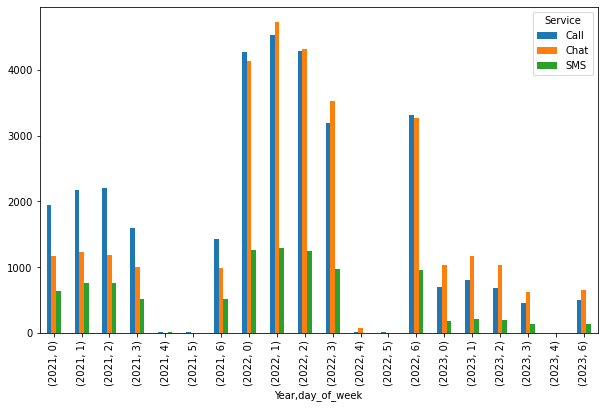

In [6]:
fig, axs = plt.subplots(figsize=(10, 6))
com['counter']=1
new=com.groupby(["day_of_week",'Year','Service'])['counter'].sum().reset_index(name ='Sum')
com_pivot = pd.pivot_table(new, 
                          values="Sum", 
                          index=['Year',"day_of_week"], 
                          columns="Service")
com_pivot.plot.bar(ax=axs)
# com_pivot.plot(ax=axs)

<AxesSubplot:xlabel='Week_Number'>

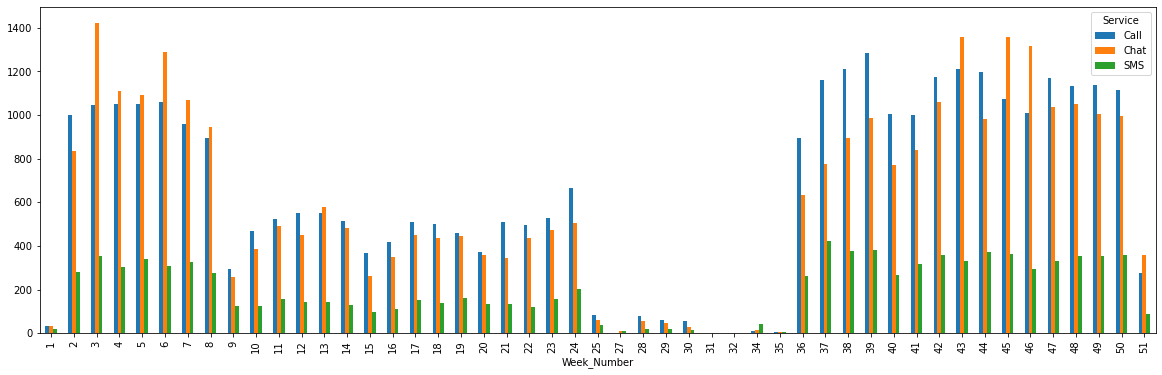

In [7]:
# Weekly over years
# a=com.groupby("Week_Number").size().values
# new=com.drop_duplicates(subset="Week_Number").assign(Count=a)
# # new.sort_values(by=['Week_number'])
# com.head()
# new.tail()
# new.plot(x='Week_Number', y='Count', kind='bar')
# plt.show()

fig, axs = plt.subplots(figsize=(20, 6))
com['counter']=1
new=com.groupby(["Week_Number",'Service'])['counter'].sum().reset_index(name ='Sum')
com_pivot = pd.pivot_table(new, 
                          values="Sum", 
                          index="Week_Number", 
                          columns="Service")

com_pivot.plot.bar(ax=axs)

<AxesSubplot:xlabel='MY'>

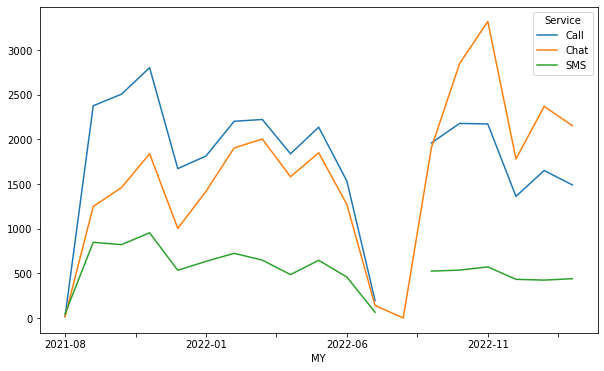

In [8]:
# Monthly over years
fig, axs = plt.subplots(figsize=(10, 6))
train = com[com.Date < pd.to_datetime("2022-12-15", format='%Y-%m-%d')]
test = com[com.Date > pd.to_datetime("2022-12-15", format='%Y-%m-%d')]
com['counter']=1
new=com.groupby(["MY",'Service'])['counter'].sum().reset_index(name ='Sum')
com_pivot = pd.pivot_table(new, 
                          values="Sum", 
                          index="MY",
                          columns="Service")

# com_pivot.plot.bar(ax=axs)
com_pivot.plot(ax=axs)

<AxesSubplot:xlabel='Year,month'>

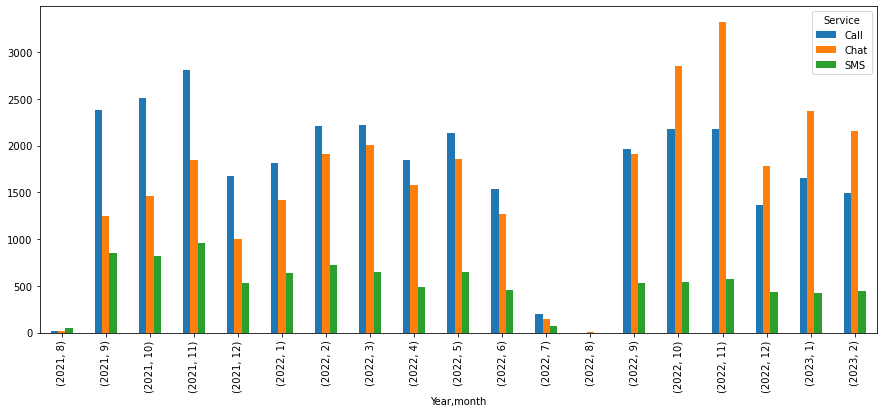

In [9]:
# Monthly over years
fig, axs = plt.subplots(figsize=(15, 6))
com['counter']=1
new=com.groupby(["month",'Service','Year'])['counter'].sum().reset_index(name ='Sum')
com_pivot = pd.pivot_table(new, 
                          values="Sum", 
                          index=['Year','month'], 
                          columns="Service")

com_pivot.plot.bar(ax=axs)

# a=com.groupby("month").size().values
# new=com.drop_duplicates(subset="month").assign(Count=a)
# new.sort_values(by=['month'])
# com.head()
# new.tail()
# new.plot(x='month', y='Count', kind='bar')
# plt.show()

C:\Users\kklau\AppData\Local\Temp\ipykernel_19668\3578916293.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['counter']=1


Service             Call       Chat    SMS
day_of_week heure                         
0           12       NaN   5.333333    NaN
            13     28.25  61.500000  10.25
            14     42.50  62.250000  11.75
            15     49.25  57.500000  12.50
            16      1.00   2.000000    NaN
1           11       NaN   1.000000    NaN
            12       NaN  12.000000    NaN
            13     31.20  50.800000  11.60
            14     43.20  55.600000  10.00
            15     47.00  66.800000   9.80
            16      1.00   3.000000    NaN
            19       NaN   6.000000    NaN
2           06       NaN   5.000000    NaN
            12       NaN   6.000000    NaN
            13     26.00  46.000000   5.60
            14     36.60  46.800000   8.80
            15     40.00  49.200000  10.40
            16      2.00   3.000000   1.00
3           12       NaN   6.000000    NaN
            13     18.80  34.800000   5.80
            14     22.00  41.800000   4.40
           

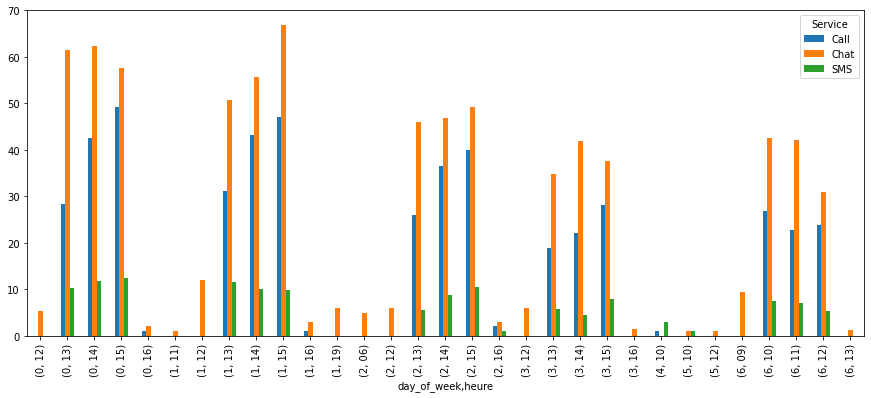

In [42]:
fig, axs = plt.subplots(figsize=(15, 6))
tmp= com.query("Date >= '2022-11-01' and Date <='2022-12-01'")
tmp['counter']=1
new=tmp.groupby(['Date',"heure",'Service'])['counter'].sum().reset_index(name ='Sum')
new['day_of_week'] = new['Date'].dt.dayofweek
new=new.groupby(['day_of_week','heure','Service'])['Sum'].mean().reset_index(name ='Mean')
new.head()
com_pivot = pd.pivot_table(new, 
                          values="Mean", 
                          index=['day_of_week',"heure"], 
                          columns="Service")

com_pivot.plot.bar(ax=axs)
print(com_pivot)

<AxesSubplot:xlabel='heure'>

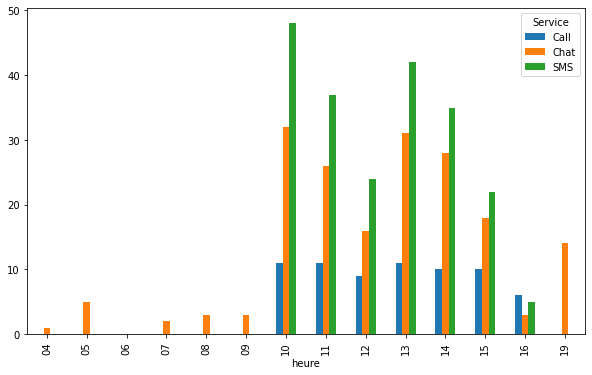

In [11]:
fig, axs = plt.subplots(figsize=(10, 6))
com['counter']=1
com = com.query("Date >= '2022-08-1'")
new=com.groupby(["heure",'Service'])['temps_comm'].mean().reset_index(name ='Sum')
new['Sum']=new['Sum']//60
com_pivot = pd.pivot_table(new, 
                          values="Sum", 
                          index="heure", 
                          columns="Service")

com_pivot.plot.bar(ax=axs)

<AxesSubplot:xlabel='month,Matiere'>

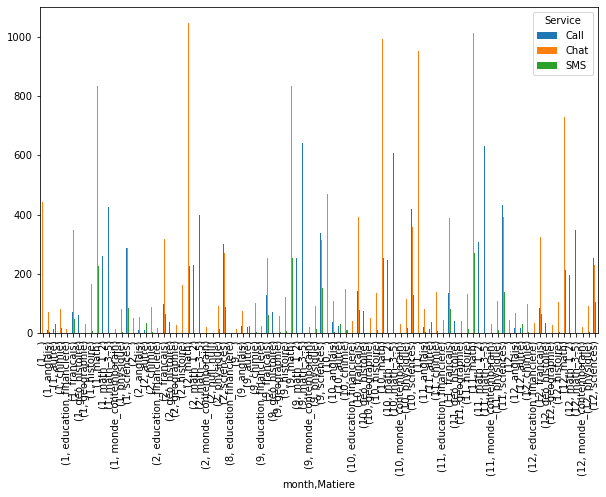

In [12]:
fig, axs = plt.subplots(figsize=(10, 6))
com['counter']=1
new=com.groupby(["month",'Service','Matiere'])['counter'].sum().reset_index(name ='Sum')
com_pivot = pd.pivot_table(new, 
                          values="Sum", 
                          index=["month", 'Matiere'], 
                          columns="Service")

com_pivot.plot.bar(ax=axs)

<AxesSubplot:xlabel='Matiere'>

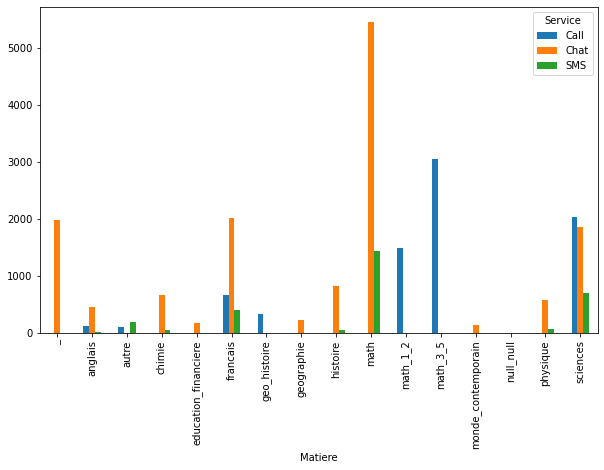

In [13]:
fig, axs = plt.subplots(figsize=(10, 6))
com['counter']=1
new=com.groupby(['Matiere','Service'])['counter'].sum().reset_index(name ='Sum')
com_pivot = pd.pivot_table(new, 
                          values="Sum", 
                          index='Matiere', 
                          columns="Service")

com_pivot.plot.bar(ax=axs)

<AxesSubplot:xlabel='Matiere'>

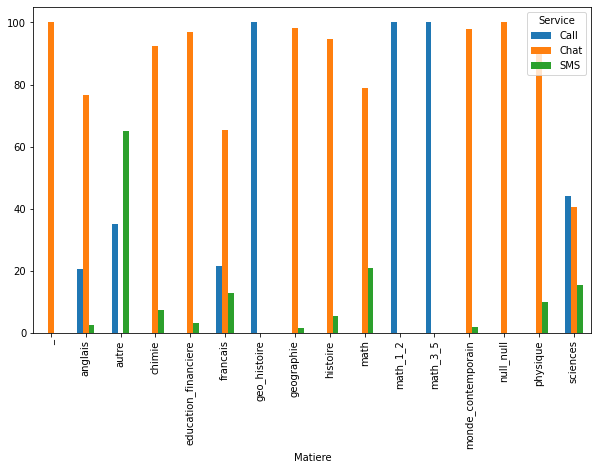

In [14]:
fig, axs = plt.subplots(figsize=(10, 6))
com['counter']=1
com= com.groupby(['Matiere', 'Service']).agg({'counter': 'sum'})
Matiere = com.groupby(['Matiere']).agg({'counter': 'sum'})
new=com.div(Matiere, level='Matiere') * 100
com_pivot = pd.pivot_table(new, 
                          values="counter", 
                          index='Matiere', 
                          columns="Service")

com_pivot.plot.bar(ax=axs)

In [15]:
h=pd.read_csv('historique_communications-20230301.csv', delimiter=',')
h.head()

,Date,Service,Direction,Langue,Record_count
0,2017-11-02,Chat,direct,fr,66
1,2017-11-02,Call,direct,fr,235
2,2017-11-03,Chat,direct,fr,3
3,2017-11-06,Chat,direct,fr,34
4,2017-11-06,Call,direct,fr,257


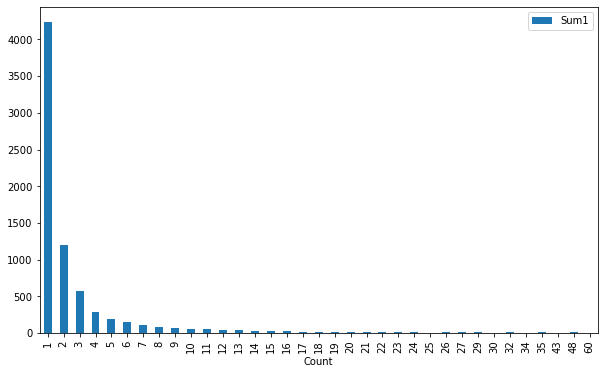

In [16]:
fig, axs = plt.subplots(figsize=(10, 6))
users=pd.read_csv('users-20230301.csv', delimiter=',')
users.head()
users['counter']=1

a=users.groupby("user").size().values
new=users.drop_duplicates(subset="user").assign(Count=a)
# new=users.groupby(["user"])['counter'].sum().reset_index(name ='Sum')
new['counter']=1
new1=new.groupby(["Count"])['counter'].sum().reset_index(name ='Sum1')
new1= new1.query("Sum1>5")
new1.plot(x='Count', y='Sum1', kind='bar', ax=axs)
plt.show()

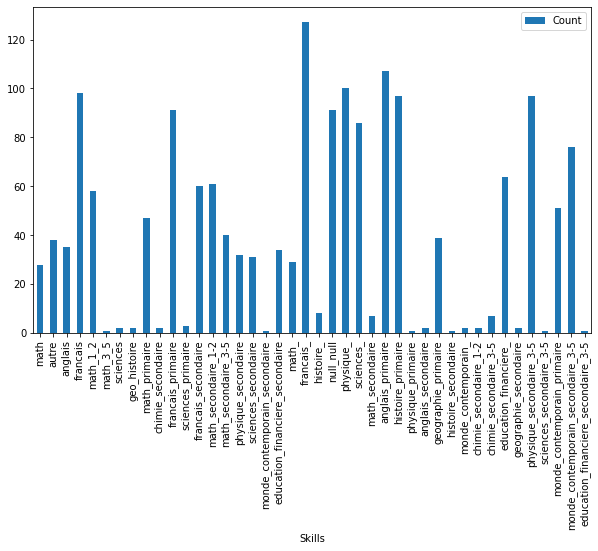

In [17]:
fig, axs = plt.subplots(figsize=(10, 6))
agents=pd.read_csv('agents-20230301.csv', delimiter=',')
agents['counter']=1

a=agents.groupby("Skills").size().values
new=agents.drop_duplicates(subset="Skills").assign(Count=a)
new.head()
new.plot(x='Skills', y='Count', kind='bar',ax=axs)
plt.show()


In [119]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")
import datetime # manipulating date formats
import itertools
import time

In [120]:

com=pd.read_csv('details_communications-20230301.csv', delimiter=',')
# alltype=([('f0','str'),('f1','date'),('f2','str'),('f3','str'),('f4','str'), ('f5', ''), ('f6', 'f8'),('f7','f8'),('f8','f8'),('f9','i8'),('f10','i8')])
# com=np.genfromtxt(completename,delimiter=",",dtype=alltype,usecols=[0,1,2,3,4,5,6,7,8,9,10], names=True)
# com=np.array(times, dtype=object)
# com.head()
com = com.query("Date >= '2021-08-01'")
com['Date'] = pd.to_datetime(com['Date'])
com['day_of_week'] = com['Date'].dt.dayofweek
com['Week_Number'] = com['Date'].dt.isocalendar().week
com["month"] = com["Date"].dt.month
com["Year"] = com["Date"].dt.year
com["MY"]= com['Date'].dt.strftime('%Y-%m')
com['heure'] = com.Time.str[0:2]
com.head()

train_end = '2022-12-22'
test_end = '2023-02-28'
demo_start = '2022-12-25'

test = com[com.Date > pd.to_datetime("2022-12-31", format='%Y-%m-%d')]
test['counter']=1

test=test.groupby(["Date",'Service'])['counter'].sum().reset_index(name ='Sum')

,Sum
Date,
2021-08-02,8.0
2021-08-04,8.0
2021-08-05,18.0
2021-08-12,2.0
2021-08-24,1.0


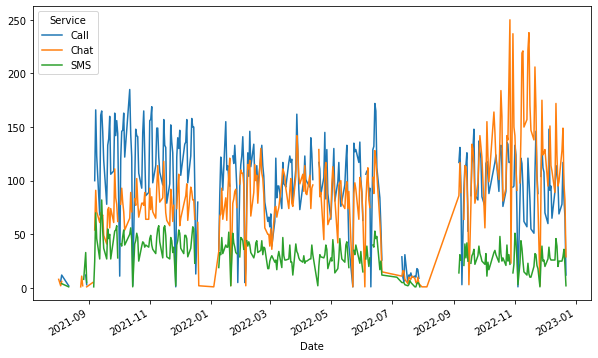

In [121]:

train= com[com.Date < pd.to_datetime("2022-12-31", format='%Y-%m-%d')]
train['counter']=1
train=train.groupby(["Date",'Service'])['counter'].sum().reset_index(name ='Sum')

com_pivot = pd.pivot_table(train, 
                          values="Sum", 
                          index="Date",
                          columns="Service")
# com_pivot.head()

# #Image 
fig, axs = plt.subplots(figsize=(10, 6))
# com_pivot.plot.bar(ax=axs)
com_pivot.plot(ax=axs)

# ##Training set 
train = com_pivot.reset_index()
train.set_index('Date')
train['Call']=train['Call'].fillna(0)
train['Chat']=train['Chat'].fillna(0)
train['SMS']=train['SMS'].fillna(0)
train['Sum']=train.iloc[:,1:3].sum(axis=1)
train=train.loc[:,['Date','Sum']]
train.columns=['Date', 'Sum']
train.set_index('Date', inplace=True)
train.columns=['Sum']
train.head()

In [122]:
test = com[com.Date > pd.to_datetime("2022-12-31", format='%Y-%m-%d')]
test['counter']=1
test=test.groupby(["Date",'Service'])['counter'].sum().reset_index(name ='Sum')
com_pivot_test = pd.pivot_table(test, 
                          values="Sum", 
                          index="Date",
                          columns="Service")
# com_pivot.head()

# com_pivot_test.plot.bar(ax=axs)
com_pivot.plot(ax=axs)
test = com_pivot_test.reset_index()
test.set_index('Date')
test['Call']=test['Call'].fillna(0)
test['Chat']=test['Chat'].fillna(0)
test['SMS']=test['SMS'].fillna(0)
test['Sum']=test.iloc[:,1:3].sum(axis=1)
test=test.loc[:,['Date','Sum']]
test.columns=['Date', 'Sum']
test.set_index('Date', inplace=True)
test.columns=['Sum']
test.tail()

,Sum
Date,
2023-02-20,261.0
2023-02-21,307.0
2023-02-22,243.0
2023-02-23,130.0
2023-02-28,1.0


In [123]:
all=pd.concat([train, test], axis=1)
all= all.sum(axis=1).to_frame(name='Sum')
all.head()

,Sum
Date,
2021-08-02,8.0
2021-08-04,8.0
2021-08-05,18.0
2021-08-12,2.0
2021-08-24,1.0


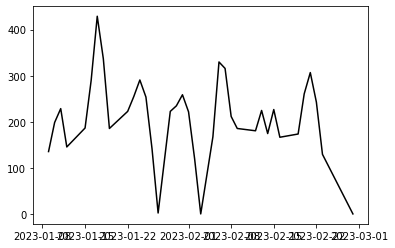

In [124]:
# plt.plot(test.index, train['Call'], )
plt.plot( test['Sum'], color='Black', label = 'Test data')

# Autoregressive Integrated Moving Average (ARIMA) regression model:    

In [125]:
from statsmodels.tsa.arima.model import ARIMA

RMSE:  96.84996538326634


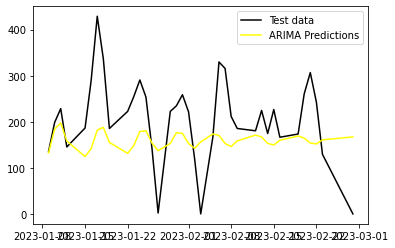

In [126]:
y = train['Sum']
ARIMAmodel = ARIMA(y, order = (2, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(test['Sum'], color='Black', label = 'Test data')
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test["Sum"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

# SARIMAX regression model: 

Results of Dickey-Fuller Test:
Test Statistic                  -4.530
p-value                          0.000
#Lags Used                       8.000
Number of Observations Used    338.000
Critical Value (1%)             -3.450
Critical Value (5%)             -2.870
Critical Value (10%)            -2.571
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -9.395
p-value                          0.000
#Lags Used                       8.000
Number of Observations Used    337.000
Critical Value (1%)             -3.450
Critical Value (5%)             -2.870
Critical Value (10%)            -2.571
dtype: float64


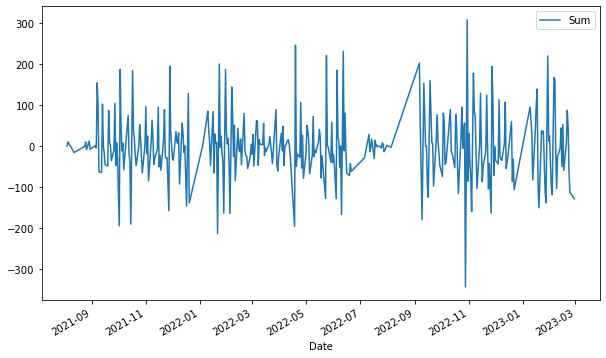

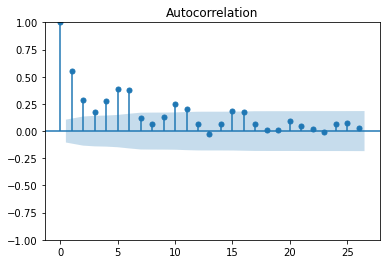

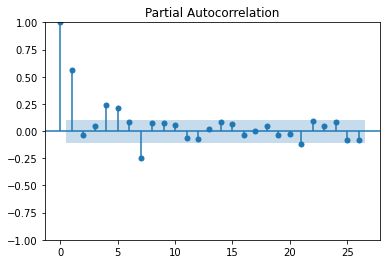

In [127]:
# train= train.sum(axis=1).to_frame(name='Sum')
# train.index.rename('Date',inplace=False)
# train.set_index('Date')
# train.head()
# test= test.sum(axis=1).to_frame(name='Sum')
# test.index.rename('Date',inplace=True)
# test.head()

def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=7*4, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (round(dfoutput,3))
    
test_stationarity(all.Sum)

def invert_diff(series, first_element_before):
    cumsum = series.cumsum()
    return cumsum.fillna(0) + first_element_original


diffed = diff(all,seasonal_periods=7)
diffed.plot(figsize=(10,6))

test_stationarity(diffed.Sum)

acf = plot_acf(all)
pacf = plot_pacf(all)

def sarimax(ts,exo,all_param):
    results = []
    for param in all_param:
        try:
            mod = SARIMAX(ts,
                          exog = exo,
                          order=param[0],
                          seasonal_order=param[1])
            res = mod.fit()
            results.append((res,res.aic,param))
            print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))
        except Exception as e:
            print(e)
            continue
            
    return results

In [128]:
###Variables exogenes

import holidays
begin = '2021-08-01'
abv = '2023-02-28'
hol = pd.to_datetime(holidays.CountryHoliday('Canada')[begin:abv])
hol=hol.strftime('%Y-%m-%d')

exo = train.copy()
exo["holidays"] = 0
exo.loc[exo.index, "day_of_week"] = "Under 150"
# exo.loc[hol] = 1

exo= pd.DataFrame().assign(holidays=exo['holidays'])
print(exo)
exo.columns=['holidays']
exo_train= exo[exo.index < pd.to_datetime("2022-12-31", format='%Y-%m-%d')]
exo_test= exo[exo.index > pd.to_datetime("2022-12-31", format='%Y-%m-%d')]

exo = test.copy()
exo["holidays"] = 0
# exo.loc[hol] = 1
exo= pd.DataFrame().assign(holidays=exo['holidays'])
print(exo)
exo.columns=['holidays']
exo_test= exo[exo.index > pd.to_datetime("2022-12-31", format='%Y-%m-%d')]

            holidays
Date                
2021-08-02         0
2021-08-04         0
2021-08-05         0
2021-08-12         0
2021-08-24         0
...              ...
2022-12-18         0
2022-12-19         0
2022-12-20         0
2022-12-21         0
2022-12-22         0

[310 rows x 1 columns]
            holidays
Date                
2023-01-09         0
2023-01-10         0
2023-01-11         0
2023-01-12         0
2023-01-15         0
2023-01-16         0
2023-01-17         0
2023-01-18         0
2023-01-19         0
2023-01-22         0
2023-01-23         0
2023-01-24         0
2023-01-25         0
2023-01-26         0
2023-01-27         0
2023-01-29         0
2023-01-30         0
2023-01-31         0
2023-02-01         0
2023-02-02         0
2023-02-03         0
2023-02-05         0
2023-02-06         0
2023-02-07         0
2023-02-08         0
2023-02-09         0
2023-02-12         0
2023-02-13         0
2023-02-14         0
2023-02-15         0
2023-02-16         0
2023-02-19

In [129]:
# set parameter range
p,d,q = range(0,3),[1],range(0,3)
P,D,Q,s = range(0,3),[1],range(0,3),[7]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))

all_res = sarimax(train,exo_train,all_param)

Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 7) - AIC:3774.2
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 7) - AIC:3525.48
Tried out SARIMAX(0, 1, 0)x(0, 1, 2, 7) - AIC:3507.78
Tried out SARIMAX(0, 1, 0)x(1, 1, 0, 7) - AIC:3643.41
Tried out SARIMAX(0, 1, 0)x(1, 1, 1, 7) - AIC:3509.68
Tried out SARIMAX(0, 1, 0)x(1, 1, 2, 7) - AIC:3508.37
Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 7) - AIC:3600.2
Tried out SARIMAX(0, 1, 0)x(2, 1, 1, 7) - AIC:3510.51
Tried out SARIMAX(0, 1, 0)x(2, 1, 2, 7) - AIC:3510.06
Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 7) - AIC:3697.93
Tried out SARIMAX(0, 1, 1)x(0, 1, 1, 7) - AIC:3474.9
Tried out SARIMAX(0, 1, 1)x(0, 1, 2, 7) - AIC:3465.64
Tried out SARIMAX(0, 1, 1)x(1, 1, 0, 7) - AIC:3590.5
Tried out SARIMAX(0, 1, 1)x(1, 1, 1, 7) - AIC:3466.66
Tried out SARIMAX(0, 1, 1)x(1, 1, 2, 7) - AIC:3466.52
Tried out SARIMAX(0, 1, 1)x(2, 1, 0, 7) - AIC:3549.71
Tried out SARIMAX(0, 1, 1)x(2, 1, 1, 7) - AIC:3467.88
Tried out SARIMAX(0, 1, 1)x(2, 1, 2, 7) - AIC:3469.06
Tried out SARIMAX(0, 1, 2)x(0, 1

In [130]:
test.head()

,Sum
Date,
2023-01-09,136.0
2023-01-10,199.0
2023-01-11,229.0
2023-01-12,146.0
2023-01-15,187.0


[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x000001E531259C10>, 3431.1137144073887, ((2, 1, 2), (0, 1, 2, 7))), (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x000001E531311370>, 3432.700104388314, ((2, 1, 2), (1, 1, 2, 7))), (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x000001E531292FD0>, 3432.9761108143657, ((2, 1, 2), (1, 1, 1, 7))), (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x000001E531385190>, 3434.314761931791, ((2, 1, 2), (2, 1, 1, 7))), (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x000001E531385640>, 3436.274990503223, ((2, 1, 2), (2, 1, 2, 7)))]


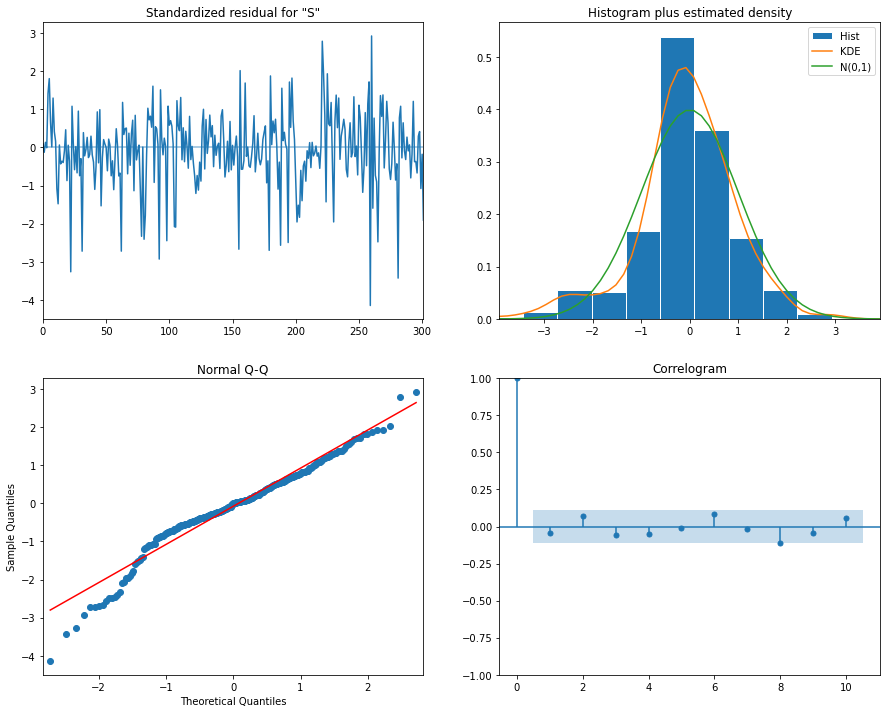

Ljung-box p-values:
[0.43868781 0.32207466 0.35986772 0.39546744 0.53354652 0.39549093
 0.49982772 0.26515003 0.30944815 0.30877934 0.38272016 0.44309726
 0.43358778 0.51146467]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               Sum   No. Observations:                  310
Model:             SARIMAX(2, 1, 2)x(0, 1, 2, 7)   Log Likelihood               -1707.557
Date:                           Fri, 17 Mar 2023   AIC                           3431.114
Time:                                   19:12:07   BIC                           3460.797
Sample:                                        0   HQIC                          3442.990
                                           - 310                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holidays            0   1.79e+05          0      1.000   -3.52e+05    3.52e+05
ar.L1          0.9785      0.145      6.764      0.000       0.695       1.262
ar.L2         -0.5197      0.079     -6.573      0.000      -0.675      -0.365
ma.L1         -1.4078      0.150     -9.384      0.000      -1.702      -1.114
ma.L2          0.6181      0.124      4.980      0.000       0.375       0.861
ma.S.L7       -1.2879      0.071    -18.093      0.000      -1.427      -1.148
ma.S.L14       0.3161      0.072      4.374      0.000       0.174       0.458
sigma2      4382.4128    278.723     15.723      0.000    3836.126    4928.700
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):                61.17
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                            -0.65
Prob(H) (two-sided):                  0.24   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [131]:
all_res.sort(key=lambda x: x[1])
print(all_res[:5])

res = all_res[0][0]
res.plot_diagnostics(figsize=(15, 12))

plt.show()
print("Ljung-box p-values:\n" + str(res.test_serial_correlation(method='ljungbox')[0][1]))
res.summary()

In [134]:
pred_test = res.get_prediction(start=train_end,end=test_end,exog=exo_test)
err = 'Mean absolute percentage error: %.2f'% MAPE(test, pred_test.predicted_mean) + \
'\nRoot mean squared error: %.2f'% sqrt(MSE(test, pred_test.predicted_mean))

pred = res.get_prediction(start=begin,end=test_end,exog=exo_test)
pred_ci = pred.conf_int()

fig, ax = plt.subplots(figsize=(12,7))
ax.set(title='Nombre de requetes', ylabel='Sum')

all.plot(ax=ax, style = 'o')
pred.predicted_mean.plot(ax=ax, style='o')
ci = pred_ci.loc[demo_start:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

plt.figtext(0.12, -0.06, err, ha="left",fontsize=15,va='center')
legend = ax.legend(["Train Set Observed","Test Set Observed", "Forecast"])

KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'

In [149]:
pred_test = res.get_prediction(start=train_end,end=test_end,exog=exo_test)
# The root mean squared error
err = 'Mean absolute percentage error: %.2f'% MAPE(test, pred_test.predicted_mean) + \
'\nRoot mean squared error: %.2f'% sqrt(MSE(test, pred_test.predicted_mean))

pred = res.get_prediction(start=demo_start,end=test_end,exog=exo_test)
pred_ci = pred.conf_int()

fig, ax = plt.subplots(figsize=(12,7))
ax.set(title='Energy consumption', ylabel='kWh')

train[demo_start:].plot(ax=ax)
test.plot(ax=ax)
pred.predicted_mean.plot(ax=ax)
ci = pred_ci.loc[demo_start:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

plt.figtext(0.12, -0.06, err, ha="left",fontsize=15,va='center')
legend = ax.legend(["Train Set Observed","Test Set Observed", "Forecast"])
ax.grid(True)


KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'

RMSE:  95.9710452911644


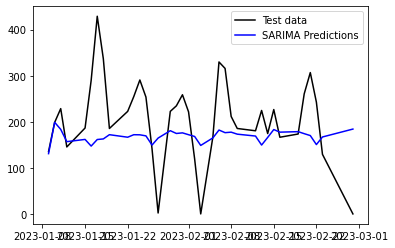

In [147]:
train.head()
test.head()
y = train['Sum']
# (2, 1, 2), (0, 1, 2, 7)))
SARIMAXmodel = SARIMAX(y, order = (2, 1, 2), seasonal_order=(0,1,2,7))
SARIMAXmodel = SARIMAXmodel.fit()
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.1) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

sarma_rmse = np.sqrt(mean_squared_error(test["Sum"].values, y_pred_df["Predictions"]))
print("RMSE: ",sarma_rmse)
plt.plot(test['Sum'], color='Black', label = 'Test data')
plt.plot(y_pred_out, color='Blue', label = 'SARIMA Predictions')
plt.legend()

In [ ]:
test.columns